File created by Jinghao Chen (jinghc2@uci.edu).

Make sure file "gfp.pkl" is in the directory.

In [2]:
import pickle
import torch
import mptools as mp
import numpy as np
# np.random.seed(114514)

In [3]:
pickle_in = open("data/data_comb.pkl","rb")
data_comb = pickle.load(pickle_in)

In [4]:
X, Y = data_comb[:,:-1], data_comb[:,-1]   # get features & target
X, Y = mp.shuffleData(X,Y)       # reorder randomly rather than by class label

In [5]:
Xtr, Ytr = X, Y
Ytr[Y<=3] = 0
Ytr[(Y>3)&(Y<=6)] = 1
Ytr[Y>6] = 2

In [6]:
Nc = len(set(Ytr)) # number of class(es)
Nc

3

In [7]:
N_comb = data_comb.shape[1]

In [8]:
N_theta = Nc-1+3 + N_comb-1 # the number of unknown parameters

Import packages for machine learning model:

In [9]:
import matplotlib.pyplot as plt   # use matplotlib for plotting with inline plots
from IPython import display
import mltools as ml

In [10]:
class logisticClassify(ml.classifier):     # trivial shell class to contain whatever we want
    def predict(self,X): pass               # we will replace the shell later as we extend the class
    def train(self,X): pass

In [11]:
def myPredict(self,X):
    '''Predict model on data X; return nparray of class predictions'''
    
    N1 = 104 # length of CRP binding sites
    
    X1 = X[:,:N1] # X1 is a CRP sequence
    X2 = X[:,N1:] # X2 is a RNAP sequence
    
    # constants for future use
    _,N = X.shape;
    Nc = len(self.theta)-N-2 # number of classes
    dN = Nc-2
    N0 = Nc+2
    
    R = 1.98e-3 # gas const
    T = 310 # temperature at which cells were induced
    RT = R*T

    eps_c = torch.Tensor(X1) @ self.theta[5:5+N1]; # CRP binding energy
    eps_r = torch.Tensor(X2) @ self.theta[5+N1:]; # RNAP binding energy
    wi = self.theta[3]*(torch.exp(-eps_r/RT)+self.theta[2]*torch.exp(-(eps_c+eps_r+self.theta[4])/RT))
    ri = wi/(1+self.theta[2]*torch.exp(-eps_c/RT)+wi)
    
    Y01 = 0
    Y01 = 1*(ri>self.theta[0])+1*(ri>self.theta[1]) 
    Y = self.classes[Y01]           # use lookup to convert back to class values if given
    return Y                        # NOTE: returns as numpy, not torch! (b/c classes is a nparray)
                                    # (This is necessary for mltools plot to work)

In [12]:
# Create a shell classifier
class logisticClassify(ml.classifier):
    predict = myPredict              #
    train = None                     # this function will be implemented later

In [71]:
def myTrain(self,X,Y,initStep=1.,stopTol=1e-4,stopEpochs=5000,alpha=0):
    """ Train the logistic regression using stochastic gradient descent """
    
    M,N = X.shape;                     # initialize the model if necessary:
    N1 = 104 # length of CRP binding sites
    # N2 = N-N1;
    X1 = X[:,:N1] # X1 is a CRP sequence
    X2 = X[:,N1:] # X2 is a RNAP sequence
    self.classes = np.unique(Y);       # Y may have two classes, any values
    # Y01 = ml.toIndex(Y,self.classes);  # Y01 is Y, but with canonical values 0 or 1
    # Y01 = Y
    Y0, Y1 = 1*(Y>0), 1*(Y>1)
    
    R = 1.98e-3 # gas const
    T = 310 # temperature at which cells were induced
    RT = R*T
    
    N_theta = 5+N # the number of unknown parameters
    # if the shape of initial theta is wrong, randomly generate a correct one
    if len(self.theta)!=N_theta: self.theta=torch.randn((N_theta,1),requires_grad = True);
    
        
    # init loop variables:
    epoch=0; done=False; Jnll=[]; J01=[];            # initialize loop variables
    myrate = lambda epoch: initStep*2.0/(2.0+epoch)  # step size as a f'n of epoch
    
    opt = torch.optim.SGD([self.theta], initStep)
    sched = torch.optim.lr_scheduler.LambdaLR(opt, myrate)
    
    
    while not done:
        # Do an SGD pass through the entire data set:
        Jnll.append(0.)
        for i in np.random.permutation(M):
            # Compute predictions and loss for *just* data X[i]:
            # Note: @ operation requires Python 3.5+
            eps_c = torch.tensor(X1[i],dtype=torch.float32) @ self.theta[5:5+N1]; # CRP binding energy
            eps_r = torch.tensor(X2[i],dtype=torch.float32) @ self.theta[5+N1:]; # RNAP binding energy
            wi = self.theta[3]*(torch.exp(-eps_r/RT)+self.theta[2]*torch.exp(-(eps_c+eps_r+self.theta[4])/RT))
            ri = wi/(1+self.theta[2]*torch.exp(-eps_c/RT)+wi)
            
            si0 = 1/(1+torch.exp(-(ri-self.theta[0])));
            si1 = 1/(1+torch.exp(-(ri-self.theta[1])));
            Ji_pre0 = -Y0[i]*torch.log(si0)-(1-Y0[i])*torch.log(1-si0); 
            Ji_pre1 = -Y1[i]*torch.log(si1)-(1-Y1[i])*torch.log(1-si1); 
            Ji_pre = Ji_pre0+Ji_pre1
#             Ji_pre = -(1-Y0[i])*torch.log(1-si0)-Y0[i]*(1-Y1[i])*torch.log(si0-si1)-Y1[i]*torch.log(si1)
            
            # add penalty to constrain the range of parameters
            Ji0 = Ji_pre + alpha*torch.maximum( self.theta[0]-self.theta[1], 0*self.theta[0])+ alpha*torch.maximum( -self.theta[0], 0*self.theta[0])+ alpha*torch.maximum( self.theta[1]-1, 0*self.theta[1]); 
            Ji1 = Ji0 + alpha*torch.maximum( self.theta[2]*(self.theta[2]-1), 0*self.theta[1])+ alpha*torch.maximum( self.theta[3]*(self.theta[3]-1), 0*self.theta[2]);
            Ji = Ji1 + alpha*torch.maximum( self.theta[4], 0*self.theta[4]);
        
            Jnll[-1] += float(Ji)/M             # find running average of surrogate loss
            opt.zero_grad()                     # Ji should be a torch.tensor of shape []
            Ji.backward()
            opt.step()
        sched.step()        

        epoch += 1

        J01.append( self.err(X,Y) )  # evaluate the current actual error rate 

        
        theta1 = self.theta.detach().numpy()
        eps_c = X1 @ theta1[5:5+N1]; # CRP binding energy
        eps_r = X2 @ theta1[5+N1:]; # RNAP binding energy
        wi = theta1[3]*(np.exp(-eps_r/RT)+theta1[2]*np.exp(-(eps_c+eps_r+theta1[4])/RT))
        tau = wi/(1+theta1[2]*np.exp(-eps_c/RT)+wi)
        
        print('at epoch '+ str(epoch) +', predict bin 1-3: '+str(sum(tau<=theta1[0]))+
              ', predict bin 4-6: '+str(sum((tau>theta1[0])*(tau<=theta1[1])))+
              ', predict bin 7-9: '+str(sum(tau>theta1[1]))+
              ', error rate: '+str(J01[-1]))
        
#         display.clear_output(wait=True); plt.figure(figsize=(15,5));
#         plt.subplot(1,2,1); 
#         plt.cla(); plt.plot(Jnll,'b-'); plt.xlabel('epoch'); plt.ylabel('surrogate loss');    # plot losses
#         plt.subplot(1,2,2); 
#         plt.cla(); plt.plot(J01,'r-'); plt.xlabel('epoch'); plt.ylabel('error rate');    # plot error rate
#         plt.show(); plt.pause(.001);                    # let OS draw the plot

        
        ## For debugging: you may want to print current parameters & losses
        # print(self.theta, ' => ', Jnll, ' / ', J01[-1] )
        # input()   # pause for keystroke

        # check stopping criteria: exit if exceeded # of epochs ( > stopEpochs)
        done = epoch > stopEpochs or abs(Jnll[-1]) < stopTol;   # or if Jnll not changing between epochs ( < stopTol )


In [72]:
theta_ini = np.array([.2,.8,.06,.5,-3.26]+[0]*(N_comb-1)).reshape(N_theta,1) 

In [74]:
# Update our shell classifier definition
class logisticClassify(ml.classifier):
    predict = myPredict              # Now all parts are implemented
    train = myTrain

learnerA = logisticClassify()
learnerA.classes = np.unique(Ytr)
learnerA.theta = torch.tensor(theta_ini,requires_grad = True,dtype=torch.float32) # TODO
learnerA.train(Xtr,Ytr,initStep=2e-1,stopEpochs=10,stopTol=1e-5,alpha=10);

at epoch 1, predict bin 1-3: [16745], predict bin 4-6: [11746], predict bin 7-9: [17563], error rate: 0.3566031180787771
at epoch 2, predict bin 1-3: [26145], predict bin 4-6: [8044], predict bin 7-9: [11865], error rate: 0.36902332044990666
at epoch 3, predict bin 1-3: [0], predict bin 4-6: [33858], predict bin 7-9: [12196], error rate: 0.4497329222217397
at epoch 4, predict bin 1-3: [22300], predict bin 4-6: [8606], predict bin 7-9: [15148], error rate: 0.3295913492856212
at epoch 5, predict bin 1-3: [21956], predict bin 4-6: [11873], predict bin 7-9: [12225], error rate: 0.3382116645676814
at epoch 6, predict bin 1-3: [15429], predict bin 4-6: [16565], predict bin 7-9: [14060], error rate: 0.34103443783384724
at epoch 7, predict bin 1-3: [21014], predict bin 4-6: [17282], predict bin 7-9: [7758], error rate: 0.39924870803838974
at epoch 8, predict bin 1-3: [20883], predict bin 4-6: [11121], predict bin 7-9: [14050], error rate: 0.32761540799930516
at epoch 9, predict bin 1-3: [19092

Change back into numpy format for visualization and analysis, and save it if necessary.

In [75]:
theta_np = learnerA.theta.detach().numpy()

In [77]:
pickle_out = open("data/theta230809joint3classes.pkl","wb")
pickle.dump(theta_np, pickle_out)
pickle_out.close()

In [76]:
theta_np[:5] # value after 500 epochs

array([[ 0.05177455],
       [ 0.97258574],
       [ 0.2621972 ],
       [ 0.57422715],
       [-7.079043  ]], dtype=float32)

In [32]:
theta_np[:5] # value after 100 epochs

array([[ 2.1351126e-03],
       [ 9.9918759e-01],
       [ 3.5778753e-02],
       [ 6.9543153e-02],
       [-5.8541918e+00]], dtype=float32)

In [57]:
theta_np[:4] # value after 30 epochs

array([[ 0.49115813],
       [ 0.04972205],
       [ 0.06942279],
       [-4.7296476 ]], dtype=float32)

In [79]:
# pickle_out = open("data/theta230727joint272param.pkl","wb")
# pickle.dump(theta_np, pickle_out)
# pickle_out.close()

In [33]:
def energy_matrix(theta_raw, plot = False):
    '''generate energy matrix, the normalized energy vector and related constants'''
    '''input theta_raw has NO intercept term (pure energy vector with no shifting term)'''
    n = int((theta_raw.shape[0])/4)
    theta_shift = 0 # initialize energy shift
    theta = np.transpose(np.reshape(theta_raw,(n,4)))
    for i in range(n):
        theta_shift += min(theta[:,i]) # cummulate energy shift
        theta[:,i] -= min(theta[:,i])       
    theta_scale = theta.max() # calculate the unit/scaling factor of energy
    theta = theta/theta_scale
    theta_long = np.reshape(np.transpose(theta),theta_raw.shape)
    if plot:
        plt.matshow(theta)
        plt.colorbar(label='arbitrary unit')
        plt.style.use('classic')
        plt.show()
    return theta, theta_long, theta_shift, theta_scale

Plot the energy matrix:

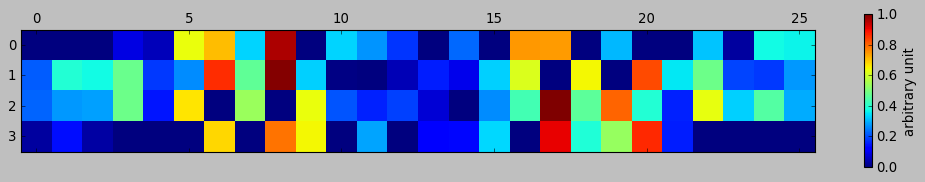

In [78]:
theta_c,_,shift_c,scale_c = energy_matrix(theta_np[5:5+104],plot = True)

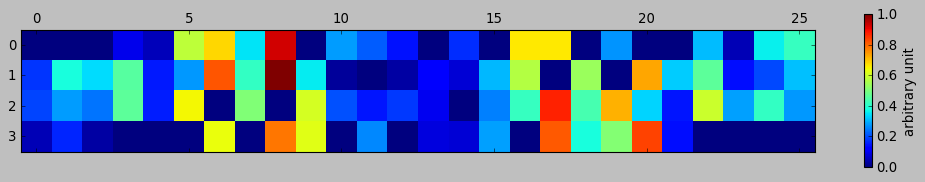

In [68]:
theta_c,_,shift_c,scale_c = energy_matrix(theta_np[4:4+104],plot = True)

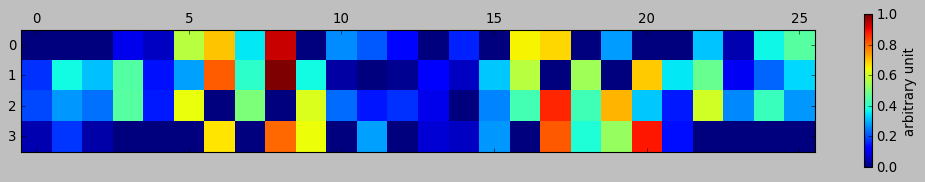

In [61]:
theta_c,_,shift_c,scale_c = energy_matrix(theta_np[4:4+104],plot = True)

Now we turn to RNAP.

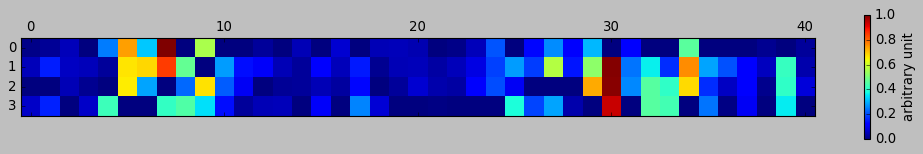

In [79]:
theta_r,_,shift_r,scale_r = energy_matrix(theta_np[5+104:],plot = True)

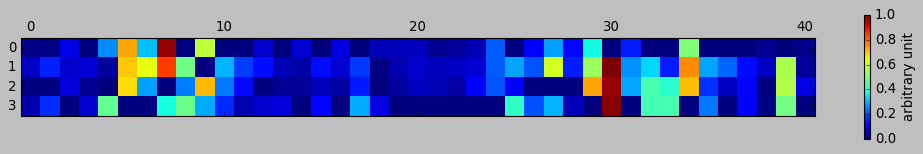

In [69]:
theta_r,_,shift_r,scale_r = energy_matrix(theta_np[4+104:],plot = True)

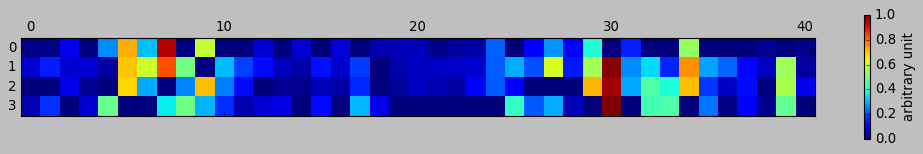

In [62]:
theta_r,_,shift_r,scale_r = energy_matrix(theta_np[4+104:],plot = True)

In [26]:
shift_c, scale_c

(0.0, 2.7204638)

In [70]:
shift_c, scale_c

(-10.055270795128308, 3.1833305)

In [63]:
shift_c, scale_c

(-8.488577060867101, 2.580164)

In [27]:
shift_r, scale_r

(0.0, 4.8883915)

In [71]:
shift_r, scale_r

(-25.09530529170297, 5.389796)

In [64]:
shift_r, scale_r

(-21.30336822476238, 4.5674458)